In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot
from statsmodels.distributions.empirical_distribution import ECDF
import warnings
warnings.simplefilter("ignore")

In [184]:
#--- [1] read data and only keep features and observations we want

def category_to_integer(category):
    if category == 'Yes':
        integer = 1
    elif category == 'No':
        integer = 0
    else:
        integer = 2
    return(integer)

url = "https://raw.githubusercontent.com/VincentGranville/Main/main/circle8d.csv"
data = pd.read_csv(url)
features = ['X1', 'X2', 'X3', 'Outcome'] 

In [185]:
data.shape

(400, 9)

In [186]:
#- [1.2] set seed for replicability

pd.core.common.random_state(None)
seed = 106 ## 105
np.random.seed(seed)

In [187]:
#- [1.3] select features

features = ['X1', 'X2', 'X3', 'Outcome'] 
data = data[features]
data = data.sample(frac = 1)  # shuffle rows to break artificial sorting

In [188]:
#- [1.4] split real dataset into training and validation sets

data_training = data.sample(frac = 0.5)
data_validation = data.drop(data_training.index)
data_training.to_csv('circle_training_vg2.csv')
data_validation.to_csv('circle_validation_vg2.csv')
data_train = pd.DataFrame.to_numpy(data_training)

nobs = len(data_training)
n_features = len(features)

In [189]:
#--- [2] create initial synthetic data  

nobs_synth = 400

data_synth = np.empty(shape=(nobs_synth,n_features))
eps = 0.000000001

for i in range(nobs_synth):
    pc = np.random.uniform(0, 1 + eps, n_features)
    for k in range(n_features):
        label = features[k]
        data_synth[i, k] = np.quantile(data_training[label], pc[k], axis=0)

data_synthetic = pd.DataFrame(data_synth, columns = features)    
data_synthetic.to_csv('circle_synth_init.csv')

In [190]:
#--- [3] loss functions Part 1

#- [3.1] specify 2nd part of loss function (argument is a number or array)

# do not use g(arr) = f(arr) = arr: this is pre-built already as 1st term in loss fct
# these two functions f, g are for the second term in the loss function

def g(arr):
    return(np.absolute(arr))
def h(arr):
    return(np.absolute(arr)) 

symmetric = True # set to True if functions g and h are identical
# 'symmetric = True' twice as fast as 'symmetric = False'

In [191]:
#- [3.2] summary stats depending on loss function

dt_mean  = np.mean(data_train, axis=0)
dt_stdev = np.std(data_train, axis=0)
ds_mean  = np.mean(data_synth, axis=0)
ds_stdev = np.std(data_synth, axis=0)

# for g(arr)
dt_mean1  = np.mean(g(data_train), axis=0)
dt_stdev1 = np.std(g(data_train), axis=0)
ds_mean1  = np.mean(g(data_synth), axis=0)
ds_stdev1 = np.std(g(data_synth), axis=0)

# for f(arr)
dt_mean2  = np.mean(h(data_train), axis=0)
dt_stdev2 = np.std(h(data_train), axis=0)
ds_mean2  = np.mean(h(data_synth), axis=0)
ds_stdev2 = np.std(h(data_synth), axis=0)

In [213]:
#--- [4] loss function Part 2: managing loss function

# Weights hyperparameter:
#
#    1st value is for 1st term in loss function, 2nd value for 2nd term
#    each value should be between 0 and 1, all adding to 1
#    works best when loss contributions from each term are about the same

weights = [0.62, 0.38]  

#- [4.1] for very fast loss fonction update when swapping 2 values

dt_prod = np.empty(shape=(n_features,n_features))
ds_prod = np.empty(shape=(n_features,n_features))
dt_prod12 = np.empty(shape=(n_features,n_features))
ds_prod12 = np.empty(shape=(n_features,n_features))

for k in range(n_features):
    for l in range(n_features):
        dt_prod[l, k] = np.dot(data_train[:,l], data_train[:,k])
        ds_prod[l, k] = np.dot(data_synth[:,l], data_synth[:,k])
        dt_prod12[l, k] = np.dot(g(data_train[:,l]), h(data_train[:,k])) 
        ds_prod12[l, k] = np.dot(g(data_synth[:,l]), h(data_synth[:,k])) 

In [214]:
#- [4.2] loss function contribution from features (k, l) jointly

def get_distance(k, l):

    dt_prodn = dt_prod[k, l] / nobs
    ds_prodn = ds_prod[k, l] / nobs_synth
    dt_r = (dt_prodn - dt_mean[k]*dt_mean[l]) / (dt_stdev[k]*dt_stdev[l])
    ds_r = (ds_prodn - ds_mean[k]*ds_mean[l]) / (ds_stdev[k]*ds_stdev[l])

    dt_prodn12 = dt_prod12[k, l] / nobs  
    ds_prodn12 = ds_prod12[k, l] / nobs_synth 
    dt_r12 = (dt_prodn12 - dt_mean1[k]*dt_mean2[l]) / (dt_stdev1[k]*dt_stdev2[l])
    ds_r12 = (ds_prodn12 - ds_mean1[k]*ds_mean2[l]) / (ds_stdev1[k]*ds_stdev2[l])

    # dist = weights[0]*abs(dt_r - ds_r) + weights[1]*abs(dt_r12 - ds_r12) 
    dist = max(weights[0]*abs(dt_r - ds_r), weights[1]*abs(dt_r12 - ds_r12)) 
    return(dist, dt_r, ds_r, dt_r12, ds_r12)
 
def total_distance(): 

    eval = 0
    max_dist = 0
    lmax = n_features

    for k in range(n_features):
        if symmetric:
            lmax = k
        for l in range(lmax):
            if l != k: 
                values = get_distance(k, l)
                eval += values[0]
                if values[0] > max_dist:
                    max_dist = values[0]
    return(eval, max_dist)

#- [4.3] updated loss function when swapping rows idx1 and idx2 in feature k
#        contribution from feature l jointly with k

def get_new_distance(k, l, idx1, idx2):

    tmp1_k = data_synth[idx1, k]
    tmp2_k = data_synth[idx2, k]
    tmp1_l = data_synth[idx1, l]
    tmp2_l = data_synth[idx2, l]

    #-- first term of loss function

    remove1 = tmp1_k * tmp1_l
    remove2 = tmp2_k * tmp2_l
    add1 = tmp1_k * tmp2_l
    add2 = tmp2_k * tmp1_l
    new_ds_prod = ds_prod[l, k] - remove1 - remove2 + add1 + add2 

    dt_prodn = dt_prod[k, l] / nobs   
    ds_prodn = new_ds_prod / nobs_synth
    dt_r = (dt_prodn - dt_mean[k]*dt_mean[l]) / (dt_stdev[k]*dt_stdev[l])
    ds_r = (ds_prodn - ds_mean[k]*ds_mean[l]) / (ds_stdev[k]*ds_stdev[l])

    #-- second term of loss function

    remove1 = g(tmp1_k) * h(tmp1_l)
    remove2 = g(tmp2_k) * h(tmp2_l)
    add1 = g(tmp1_k) * h(tmp2_l)
    add2 = g(tmp2_k) * h(tmp1_l)
    new_ds_prod12 = ds_prod12[k, l] - remove1 - remove2 + add1 + add2       

    dt_prodn12 = dt_prod12[k, l] / nobs         
    ds_prodn12 = new_ds_prod12 / nobs_synth
    dt_r12 = (dt_prodn12 - dt_mean1[k]*dt_mean2[l]) / (dt_stdev1[k]*dt_stdev2[l])
    ds_r12 = (ds_prodn12 - ds_mean1[k]*ds_mean2[l]) / (ds_stdev1[k]*ds_stdev2[l])
 
    #--

    # new_dist = weights[0]*abs(dt_r - ds_r) + weights[1]*abs(dt_r12 - ds_r12)   
    new_dist = max(weights[0]*abs(dt_r - ds_r), weights[1]*abs(dt_r12 - ds_r12)) 
    return(new_dist, dt_r, ds_r, dt_r12, ds_r12)

In [215]:
#- [4.4] update prod tables after swapping rows idx1 and idx2 in feature k
#        update impacting feature l jointly with k

def update_product(k, l, idx1, idx2):  
    
    tmp1_k = data_synth[idx1, k]
    tmp2_k = data_synth[idx2, k]
    tmp1_l = data_synth[idx1, l]
    tmp2_l = data_synth[idx2, l]

    #-- first term of loss function

    remove1 = tmp1_k * tmp1_l
    remove2 = tmp2_k * tmp2_l
    add1 = tmp1_k * tmp2_l
    add2 = tmp2_k * tmp1_l
    ds_prod[k, l] = ds_prod[k, l] - remove1 - remove2 + add1 + add2
    ds_prod[l, k] = ds_prod[k, l] 

    #-- second term of loss function

    remove1 = g(tmp1_k) * h(tmp1_l)
    remove2 = g(tmp2_k) * h(tmp2_l)
    add1 = g(tmp1_k) * h(tmp2_l)
    add2 = g(tmp2_k) * h(tmp1_l)
    ds_prod12[k, l] = ds_prod12[k, l] - remove1 - remove2 + add1 + add2

    remove1 = h(tmp1_k) * g(tmp1_l)
    remove2 = h(tmp2_k) * g(tmp2_l)
    add1 = h(tmp1_k) * g(tmp2_l)
    add2 = h(tmp2_k) * g(tmp1_l)
    ds_prod12[l, k] = ds_prod12[l, k] - remove1 - remove2 + add1 + add2

    return()

In [216]:
#--- [5] main params, some init, util fction, just before starting 

#- [5.1] feature sampling

def sample_feature(mode, hyperParameter):
    
    # Randomly pick up one column (a feature) to swap 2 values from 2 random rows 
    # One feature is assumed to be in the right order, thus ignored

    if mode == 'Equalized': 
        u = np.random.uniform(0, 1)
        cutoff = hyperParam[0]
        feature = 0
        while cutoff < u:
            feature += 1
            cutoff += hyperParam[feature]
    else:
        feature = np.random.randint(1, n_features)  # ignore feature 0
    return(feature)

In [217]:
#- [5.2] summary stats from initial synthetization

quality, max_dist = total_distance() 
print("\nMetrics after initial synth, before deep resampling\n")
print("Distance: %8.4f" %(quality)) 
print("Max Dist: %8.4f" %(max_dist)) 

print("\nBivariate feature correlation values before deep resampling:")
print("....dt_xx for training set, ds_xx for synthetic data")
print("....xx_r for correl[k, l], xx_r12 for correl[g(k), h(l)]\n")
print("%2s %2s %8s %8s %8s %8s %8s" 
             % ('k', 'l', 'dist', 'dt_r', 'ds_r', 'dt_r12', 'ds_r12'))
print("--------------------------------------------------")

for k in range(n_features):
    for l in range(n_features):
        if k != l:
            values = get_distance(l, k)
            dist = values[0]
            dt_r = values[1]    # training, 1st term of loss function
            ds_r = values[2]    # synth., 1st term of loss function
            dt_r12 = values[3]  # training, 2nd term of loss function
            ds_r12 = values[4]  # synth., 2nd term of loss function
            print("%2d %2d %8.4f %8.4f %8.4f %8.4f %8.4f" 
                     % (k, l, dist, dt_r, ds_r, dt_r12, ds_r12)) 


Metrics after initial synth, before deep resampling

Distance:   0.0712
Max Dist:   0.0362

Bivariate feature correlation values before deep resampling:
....dt_xx for training set, ds_xx for synthetic data
....xx_r for correl[k, l], xx_r12 for correl[g(k), h(l)]

 k  l     dist     dt_r     ds_r   dt_r12   ds_r12
--------------------------------------------------
 0  1   0.0000  -0.0116  -0.0116  -0.2444  -0.2444
 0  2   0.0362   1.0000   0.9416   1.0000   0.9419
 0  3   0.0000   0.0915   0.0916   0.5772   0.5772
 1  0   0.0000  -0.0116  -0.0116  -0.2444  -0.2444
 1  2   0.0000  -0.0116  -0.0116  -0.2444  -0.2444
 1  3   0.0349   0.0234   0.0714   0.6042   0.5124
 2  0   0.0362   1.0000   0.9416   1.0000   0.9419
 2  1   0.0000  -0.0116  -0.0116  -0.2444  -0.2444
 2  3   0.0000   0.0915   0.0915   0.5772   0.5772
 3  0   0.0000   0.0915   0.0916   0.5772   0.5772
 3  1   0.0349   0.0234   0.0714   0.6042   0.5124
 3  2   0.0000   0.0915   0.0915   0.5772   0.5772


In [218]:
#- [5.3] parameters, initializations

mode = 'Equalized'   # options: 'Standard', 'Equalized' 
eps = 0.0  # -0.000001

nbatches = 1  # mininum is 1
niter = 100001
batch_size = nobs_synth // nbatches 
niter_per_batch = niter // nbatches
print("\nNumber of obs to generate: %6d" %(nobs_synth))
print("Number of obs per batch  : %6d" %(batch_size))
print("Number of iter per batch : %6d" %(niter_per_batch))
print("Number of batches        : %6d" %(nbatches))
print("\nLoss weights:\n    term 1: %6.2f\n    term 2: %6.2f" 
          %(weights[0], weights[1])) 


Number of obs to generate:    400
Number of obs per batch  :    400
Number of iter per batch : 100001
Number of batches        :      1

Loss weights:
    term 1:   0.62
    term 2:   0.38


In [219]:
#--- [6] main loop: synthetization

#- [6.1] main function
 
def deep_resampling(hyperParameter):
  
    # main function

    batch = 0
    lower_row = 0
    upper_row = batch_size
    nswaps = 0

    arr_swaps = []
    arr_history_quality = []
    arr_history_max_dist = []
    arr_time = []
    print()

    for iter in range(niter): ##     in range(nobs_synth):

        k = sample_feature(mode, hyperParameter)    
        batch = iter // niter_per_batch
        lower_row = batch * batch_size
        upper_row = lower_row + batch_size 
        idx1 = np.random.randint(lower_row, upper_row) % nobs_synth
        idx2 = np.random.randint(lower_row, upper_row) % nobs_synth
        tmp1 = data_synth[idx1, k]
        tmp2 = data_synth[idx2, k]

        delta = 0
        for l in range(n_features):  
            if l != k:
                values = get_distance(k, l)
                delta += values[0] 
                if not symmetric:  # if functions g, h are different
                    values = get_distance(l, k)
                    delta += values[0] 

        new_delta = 0
        for l in range(n_features): 
            if l != k:
                values = get_new_distance(k, l, idx1, idx2)
                new_delta += values[0] 
                if not symmetric:  # if functions g, h are different
                    values = get_new_distance(l, k, idx1, idx2)
                    new_delta += values[0]

        gain = delta - new_delta
        if gain > eps:
            for l in range(n_features):
                if l != k:
                    update_product(k, l, idx1, idx2) 
                    # update_product(l, k, idx1, idx2) 
            data_synth[idx1, k] = tmp2
            data_synth[idx2, k] = tmp1
            nswaps += 1

        if iter % 500 == 0: 
            quality, max_dist = total_distance()
            arr_swaps.append(nswaps)
            arr_history_quality.append(quality)
            arr_history_max_dist.append(max_dist)
            arr_time.append(iter)
            if iter % 5000 == 0:
                print("Iter: %6d    Distance: %8.4f     Number of swaps: %6d" 
                         %(iter, quality, nswaps)) 
    return(nswaps, arr_swaps, arr_history_quality, arr_history_max_dist, arr_time)

In [220]:
#- [6.2] save synthetic data, show some stats

def evaluate_and_save(history, output_syntheticData_filename): 

    print("\nHyperparameter vector:")
    for k in range(len(hyperParam)):
        print("    feature %2d: value: %6.2f" %(k, hyperParam[k]))

    print("\nMetrics after deep resampling\n")
    quality, max_dist = total_distance()
    print("Distance: %8.4f" %(quality)) 
    print("Max Dist: %8.4f" %(max_dist)) 
    nswaps = history[0]
    print("Number of swaps: %6d" %(nswaps)) 

    data_synthetic = pd.DataFrame(data_synth, columns = features)
    data_synthetic.to_csv(output_syntheticData_filename)
    print("\nSynthetic data, first 10 rows\n",data_synthetic.head(10))

    print("\nBivariate feature correlation values after deep resampling:")
    print("....dt_xx for training set, ds_xx for synthetic data")
    print("....xx_r for correl[k, l], xx_r12 for correl[g(k), h(l)]\n")
    print("%2s %2s %8s %8s %8s %8s %8s" 
             % ('k', 'l', 'dist', 'dt_r', 'ds_r', 'dt_r12', 'ds_r12'))
    print("--------------------------------------------------")
    for k in range(n_features):
        for l in range(n_features):
            if k != l:
                values = get_distance(l, k)
                dist = values[0]
                dt_r = values[1]    # training, 1st term of loss function
                ds_r = values[2]    # synth., 1st term of loss function
                dt_r12 = values[3]  # training, 2nd term of loss function
                ds_r12 = values[4]  # synth., 2nd term of loss function
                print("%2d %2d %8.4f %8.4f %8.4f %8.4f %8.4f" 
                       % (k, l, dist, dt_r, ds_r, dt_r12, ds_r12)) 
    return()

In [221]:
#- [6.3] plot history of loss function, and cumulated number of swaps

def plot_history(history):

    arr_swaps = history[1]
    arr_history_quality = history[2]
    arr_history_max_dist = history[3]
    arr_time = history[4]

    mpl.rcParams['axes.linewidth'] = 0.3
    plt.rc('xtick',labelsize=7)
    plt.rc('ytick',labelsize=7)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.subplot(1, 2, 1)
    plt.plot(arr_time, arr_swaps, linewidth = 0.3)
    plt.legend(['cumulated swaps'], fontsize="7", 
        loc ="upper center", ncol=1)
    plt.subplot(1, 2, 2)
    plt.plot(arr_time, arr_history_quality, linewidth = 0.3)
    plt.plot(arr_time, arr_history_max_dist, linewidth = 0.3)
    plt.legend(['distance','max dist'], fontsize="7", 
        loc ="upper center", ncol=2)
    plt.show()
    return()

In [222]:
%matplotlib inline
import matplotlib.pyplot as plt


Now deep resampling starting...


Iter:      0    Distance:   0.0712     Number of swaps:      0
Iter:   5000    Distance:   0.0637     Number of swaps:     62
Iter:  10000    Distance:   0.0609     Number of swaps:    117
Iter:  15000    Distance:   0.0598     Number of swaps:    141
Iter:  20000    Distance:   0.0591     Number of swaps:    181
Iter:  25000    Distance:   0.0582     Number of swaps:    222
Iter:  30000    Distance:   0.0575     Number of swaps:    249
Iter:  35000    Distance:   0.0574     Number of swaps:    259
Iter:  40000    Distance:   0.0573     Number of swaps:    281
Iter:  45000    Distance:   0.0566     Number of swaps:    312
Iter:  50000    Distance:   0.0560     Number of swaps:    341
Iter:  55000    Distance:   0.0559     Number of swaps:    351
Iter:  60000    Distance:   0.0558     Number of swaps:    374
Iter:  65000    Distance:   0.0556     Number of swaps:    388
Iter:  70000    Distance:   0.0555     Number of swaps:    400
Iter:  75000    Dist

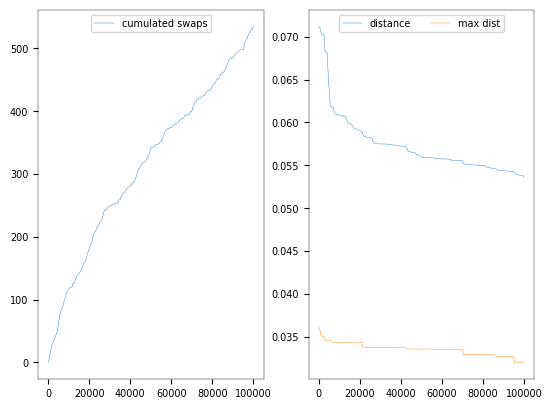

()

In [223]:
print("\nNow deep resampling starting...\n")

# hyperParam = [0.25, 0.25, 0.25, 0.25] 
# hyperParam = [0.15, 0.15, 0.70, 0.00]

hyperParam = [0.25, 0.25, 0.25, 0.25]  # for circle dataset
history = deep_resampling(hyperParam)
evaluate_and_save(history, 'circle_synth_vg2.csv')
plot_history(history)


Iter:      0    Distance:   0.0536     Number of swaps:      0
Iter:   5000    Distance:   0.0533     Number of swaps:     23
Iter:  10000    Distance:   0.0530     Number of swaps:     41
Iter:  15000    Distance:   0.0528     Number of swaps:     54
Iter:  20000    Distance:   0.0527     Number of swaps:     64
Iter:  25000    Distance:   0.0526     Number of swaps:     78
Iter:  30000    Distance:   0.0522     Number of swaps:    109
Iter:  35000    Distance:   0.0520     Number of swaps:    122
Iter:  40000    Distance:   0.0516     Number of swaps:    139
Iter:  45000    Distance:   0.0515     Number of swaps:    153
Iter:  50000    Distance:   0.0513     Number of swaps:    168
Iter:  55000    Distance:   0.0513     Number of swaps:    184
Iter:  60000    Distance:   0.0511     Number of swaps:    204
Iter:  65000    Distance:   0.0510     Number of swaps:    222
Iter:  70000    Distance:   0.0508     Number of swaps:    243
Iter:  75000    Distance:   0.0507     Number of swaps

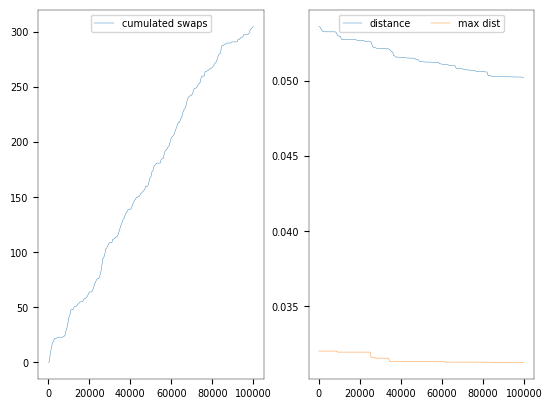

()

In [224]:
hyperParam = [0.25, 0.25, 0.25, 0.25]  # for circle dataset
history = deep_resampling(hyperParam)
evaluate_and_save(history, 'circle_synth_vg2.csv')
plot_history(history)

In [225]:
#--- [7] Evaluation synthetization using joint ECDF & Kolmogorov-Smirnov distance

#        dataframes: df = synthetic; data = real data,
#        compute multivariate ecdf on validation set, sort it by value (from 0 to 1) 

def string_to_numbers(string):

    string = string.replace("[", "")
    string = string.replace("]", "")
    string = string.replace(" ", "")
    arr = string.split(',')
    arr = [eval(i) for i in arr]
    return(arr)

In [226]:
#- [7.1] compute ecdf on validation set (to later compare with that on synth data)

def compute_ecdf(dataframe, n_nodes, adjusted):

    # Monte-Carlo: sampling n_nodes locations (combos) for ecdf
    #    - adjusted correct for sparsity in high ecdf, but is sparse in low ecdf  
    #    - non-adjusted is the other way around
    # for faster computation: pre-compute percentiles for each feature
    # foe faster computation: optimize the computation of n_nodes SQL-like queries

    ecdf = {} 

    for point in range(n_nodes):

        if point % 100 == 0:
            print("sampling ecdf, location = %4d (adjusted = %s):" % (point, adjusted))
        combo = np.random.uniform(0, 1, n_features)
        if adjusted:
            combo = combo**(1/n_features)
        z = []   # multivariate quantile
        query_string = ""
        for k in range(n_features):
            label = features[k]
            dr = data_validation[label]
            percentile = combo[k] 
            z.append(eps + np.quantile(dr, percentile))
            if k == 0:
                query_string += "{} <= {}".format(label, z[k])
            else: 
                query_string += " and {} <= {}".format(label, z[k])

        countifs = len(data_validation.query(query_string))
        if countifs > 0: 
            ecdf[str(z)] = countifs / len(data_validation)
    ecdf = dict(sorted(ecdf.items(), key=lambda item: item[1]))

    # extract table with locations (ecdf argument) and ecdf values:
    #     - cosmetic change to return output easier to handle than ecdf 

    idx = 0
    arr_location = []
    arr_value = []
    for location in ecdf:
        value = ecdf[location]
        location = string_to_numbers(location)
        arr_location.append(location)
        arr_value.append(value)
        idx += 1

    print("\n")
    return(arr_location, arr_value)

In [227]:
print("\nMultivariate ECDF computations:\n")
n_nodes = 1000   # number of random locations in feature space, where ecdf is computed
reseed = True
if reseed:
    seed = 555
    np.random.seed(seed) 
arr_location1, arr_value1 = compute_ecdf(data_validation, n_nodes, adjusted = True)
arr_location2, arr_value2 = compute_ecdf(data_validation, n_nodes, adjusted = False)


Multivariate ECDF computations:

sampling ecdf, location =    0 (adjusted = True):
sampling ecdf, location =  100 (adjusted = True):
sampling ecdf, location =  200 (adjusted = True):
sampling ecdf, location =  300 (adjusted = True):
sampling ecdf, location =  400 (adjusted = True):
sampling ecdf, location =  500 (adjusted = True):
sampling ecdf, location =  600 (adjusted = True):
sampling ecdf, location =  700 (adjusted = True):
sampling ecdf, location =  800 (adjusted = True):
sampling ecdf, location =  900 (adjusted = True):


sampling ecdf, location =    0 (adjusted = False):
sampling ecdf, location =  100 (adjusted = False):
sampling ecdf, location =  200 (adjusted = False):
sampling ecdf, location =  300 (adjusted = False):
sampling ecdf, location =  400 (adjusted = False):
sampling ecdf, location =  500 (adjusted = False):
sampling ecdf, location =  600 (adjusted = False):
sampling ecdf, location =  700 (adjusted = False):
sampling ecdf, location =  800 (adjusted = False):
sampl

In [228]:
#- [7.2] comparison: synthetic (based on training set) vs real (validation set)

def ks_delta(SyntheticData, locations, ecdf_ValidationSet):

    # SyntheticData is a dataframe
    # locations are the points in the feature space where ecdf is computed
    # for the validation set, ecdf values are stored in ecdf_ValidationSet
    # here we compute ecdf for the synthetic data, at the specified locations
    # output ks_max in [0, 1] with 0 = best, 1 = worst

    ks_max = 0
    ecdf_real = []
    ecdf_synth = []
    for idx in range(len(locations)):
        location = locations[idx]
        value = ecdf_ValidationSet[idx]
        query_string = ""
        for k in range(n_features):
            label = features[k]
            if k == 0:
                query_string += "{} <= {}".format(label, location[k])
            else: 
                query_string += " and {} <= {}".format(label, location[k])
        countifs = len(SyntheticData.query(query_string))
        synth_value = countifs / len(SyntheticData)
        ks = abs(value - synth_value)
        ecdf_real.append(value)
        ecdf_synth.append(synth_value)
        if ks > ks_max:
            ks_max = ks
        # print("location ID: %6d | ecdf_real: %6.4f | ecdf_synth: %6.4f"
        #             %(idx, value, synth_value))
    return(ks_max, ecdf_real, ecdf_synth)

In [229]:
df = pd.read_csv('circle_synth_vg2.csv')
ks_max1, ecdf_real1, ecdf_synth1 = ks_delta(df, arr_location1, arr_value1)
ks_max2, ecdf_real2, ecdf_synth2 = ks_delta(df, arr_location2, arr_value2)
ks_max = max(ks_max1, ks_max2)
print("Test ECDF Kolmogorof-Smirnov dist. (synth. vs valid.): %6.4f" %(ks_max))

Test ECDF Kolmogorof-Smirnov dist. (synth. vs valid.): 0.1225


In [230]:
#- [7.3] comparison: training versus validation set

df = pd.read_csv('circle_training_vg2.csv')
base_ks_max1, ecdf_real1, ecdf_synth1 = ks_delta(df, arr_location1, arr_value1)
base_ks_max2, ecdf_real2, ecdf_synth2 = ks_delta(df, arr_location2, arr_value2)
base_ks_max = max(base_ks_max1, base_ks_max2)
print("Base ECDF Kolmogorof-Smirnov dist. (train. vs valid.): %6.4f" %(base_ks_max))

Base ECDF Kolmogorof-Smirnov dist. (train. vs valid.): 0.1050


In [231]:
#--- [8] visualizations (based on MatPlotLib version: 3.7.1)

def vg_scatter(df, feature1, feature2, counter):

    # customized plots, subplot position based on counter

    label = feature1 + " vs " + feature2
    x = df[feature1].to_numpy()
    y = df[feature2].to_numpy()
    plt.subplot(3, 2, counter)
    plt.scatter(x, y, s = 0.1, c ="blue")
    plt.xlabel(label, fontsize = 7)
    plt.xticks([])
    plt.yticks([])
    #plt.ylim(0,70000)
    #plt.xlim(18,64)
    return()

def vg_histo(df, feature, counter):

    # customized plots, subplot position based on counter

    y = df[feature].to_numpy()
    plt.subplot(2, 3, counter)
    min = np.min(y)
    max = np.max(y)
    binBoundaries = np.linspace(min, max, 30)
    plt.hist(y, bins=binBoundaries, color='white', align='mid',edgecolor='red',
              linewidth = 0.3) 
    plt.xlabel(feature, fontsize = 7)
    plt.xticks([])
    plt.yticks([])
    return()

In [232]:
data.head()

,X1,X2,X3,Outcome
144,1.59,-1.22,1.59,1
275,-0.85,0.52,-0.85,0
166,-0.91,-0.41,-0.91,0
56,-1.99,-0.23,-1.99,1
67,1.43,1.40,1.43,1


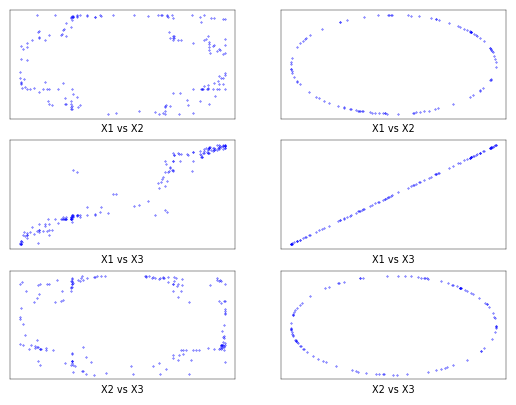

In [233]:
mpl.rcParams['axes.linewidth'] = 0.3

#- [8.1] scatterplots for Churn = 'No'

dfs = pd.read_csv('circle_synth_vg2.csv')
dfs.drop(dfs[dfs['Outcome'] == 0].index, inplace = True)
dfv = pd.read_csv('circle_validation_vg2.csv')
dfv.drop(dfv[dfv['Outcome'] == 0].index, inplace = True)

vg_scatter(dfs, 'X1', 'X2', 1)
vg_scatter(dfv, 'X1', 'X2', 2)
vg_scatter(dfs, 'X1', 'X3', 3)
vg_scatter(dfv, 'X1', 'X3', 4)
vg_scatter(dfs, 'X2', 'X3', 5)
vg_scatter(dfv, 'X2', 'X3', 6)

plt.show()

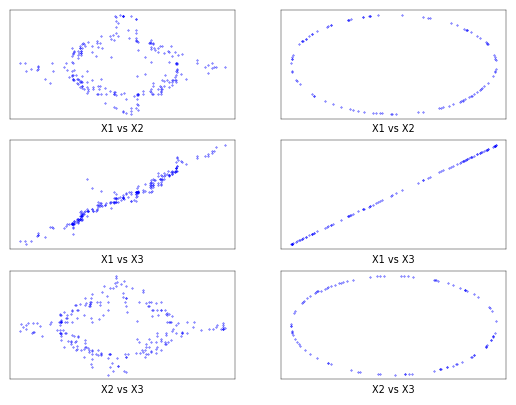

In [234]:
#- [8.2] scatterplots for Churn = 'Yes'

dfs = pd.read_csv('circle_synth_vg2.csv')
dfs.drop(dfs[dfs['Outcome'] == 1].index, inplace = True)
dfv = pd.read_csv('circle_validation_vg2.csv')
dfv.drop(dfv[dfv['Outcome'] == 1].index, inplace = True)
n_churn_yes_synth = len(dfs. index) 
n_churn_yes_valid = len(dfv. index) 

vg_scatter(dfs, 'X1', 'X2', 1)
vg_scatter(dfv, 'X1', 'X2', 2)
vg_scatter(dfs, 'X1', 'X3', 3)
vg_scatter(dfv, 'X1', 'X3', 4)
vg_scatter(dfs, 'X2', 'X3', 5)
vg_scatter(dfv, 'X2', 'X3', 6)
plt.show()

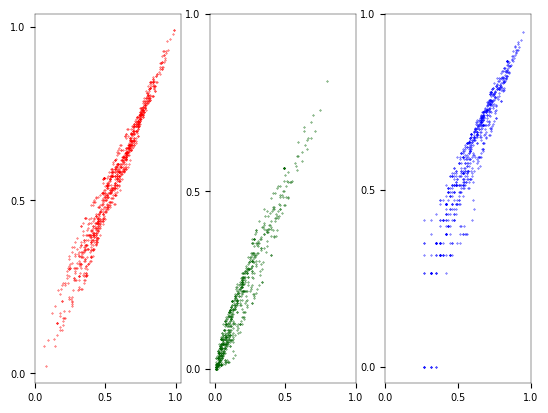

In [235]:
#- [8.3] ECDF scatterplot: validation set vs. synth data 

mpl.rcParams['axes.linewidth'] = 0.3
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlim(0,1)
plt.ylim(0,1)
x_labels = { 0 : "0.0", 0.5 : "0.5", 1: "1.0"}
y_labels = { 0 : "0.0", 0.5 : "0.5", 1: "1.0"}
plt.xticks(list(x_labels.keys()), x_labels.values())
plt.yticks(list(y_labels.keys()), y_labels.values())
plt.subplot(1, 3, 1)
plt.scatter(ecdf_real1, ecdf_synth1, s = 0.1, c ="red")
plt.xticks(list(x_labels.keys()), x_labels.values())
plt.yticks(list(y_labels.keys()), y_labels.values())
plt.subplot(1, 3, 2)
plt.scatter(ecdf_real2, ecdf_synth2, s = 0.1, c ="darkgreen")
plt.xticks(list(x_labels.keys()), x_labels.values())
plt.yticks(list(y_labels.keys()), y_labels.values())
# plt.show()

ecdf_realx = []
ecdf_synthx = []
for i in range(len(ecdf_real2)):
    ecdf_realx.append((ecdf_real2[i])**(1/n_features))
    ecdf_synthx.append((ecdf_synth2[i])**(1/n_features))
ecdf_realx = np.array(ecdf_realx)
ecdf_synthx = np.array(ecdf_synthx)
plt.subplot(1, 3, 3)
plt.scatter(ecdf_realx, ecdf_synthx, s = 0.1, c ="blue")
plt.xticks(list(x_labels.keys()), x_labels.values())
plt.yticks(list(y_labels.keys()), y_labels.values())
plt.show()

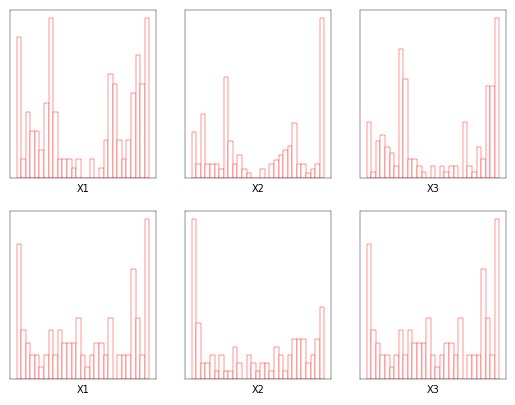

In [236]:
#- [8.4] histograms, Churn = 'No'

dfs = pd.read_csv('circle_synth_vg2.csv')
dfs.drop(dfs[dfs['Outcome'] == 0].index, inplace = True)
dfv = pd.read_csv('circle_validation_vg2.csv')
dfv.drop(dfv[dfv['Outcome'] == 0].index, inplace = True)
n_churn_no_synth = len(dfs. index) 
n_churn_no_valid = len(dfv. index) 

vg_histo(dfs, 'X1', 1)
vg_histo(dfs, 'X2', 2)
vg_histo(dfs, 'X3', 3)
vg_histo(dfv, 'X1', 4)
vg_histo(dfv, 'X2', 5)
vg_histo(dfv, 'X3', 6)
plt.show()

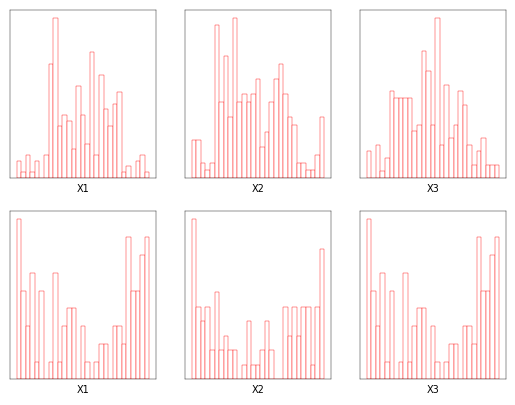

In [237]:
#- [8.5] histograms, Churn = 'Yes'

dfs = pd.read_csv('circle_synth_vg2.csv')
dfs.drop(dfs[dfs['Outcome'] == 1].index, inplace = True)
dfv = pd.read_csv('circle_validation_vg2.csv')
dfv.drop(dfv[dfv['Outcome'] == 1].index, inplace = True)
vg_histo(dfs, 'X1', 1)
vg_histo(dfs, 'X2', 2)
vg_histo(dfs, 'X3', 3)
vg_histo(dfv, 'X1', 4)
vg_histo(dfv, 'X2', 5)
vg_histo(dfv, 'X3', 6)
plt.show()

In [238]:
print("\n")
print("Churn = Yes (Synth. obs.)", n_churn_yes_synth)
print("Churn = No  (Synth. obs.)", n_churn_no_synth)
print("Churn = Yes (Valid. obs.)", n_churn_yes_valid)
print("Churn = No  (Valid. obs.)", n_churn_no_valid)



Churn = Yes (Synth. obs.) 236
Churn = No  (Synth. obs.) 165
Churn = Yes (Valid. obs.) 98
Churn = No  (Valid. obs.) 102
